# CHAPTER 3
**CNN and RNN Using PyTorch**

In [1]:
import torch
import sklearn
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

TIME_STEP = 10
INPUT_SIZE = 1
EPOCH = 60
LEARNING_RATE = 0.02

## Recipe 3-9. Implementing a RNN for Regression Problems

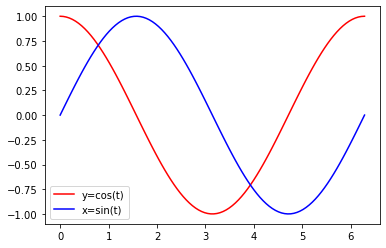

In [2]:
t = np.linspace(0, 2 * np.pi, 100, dtype=float)
x = np.sin(t)
y = np.cos(t)
plt.plot(t, y, 'r-', label='y=cos(t)')
plt.plot(t, x, 'b-', label='x=sin(t)')
plt.legend(loc='best')
plt.show()

Here we use nonlinear periodical pattern between I/O data.

Time step means that the last 10 values predict the current value and the rolling happens after that.

## Recipe 3-10. Using PyTorch Built-in Functions

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(
            input_size = INPUT_SIZE,
            hidden_size = 32,
            num_layers = 1,
            batch_first = True
        )
        self.out = nn.Linear(32, 1)
        
    def forward(self, x, h_state):
        # x.shape = (BATCH_SIZE, TIME_STEP, INPUT_SIZE)
        # h_state.shape = (n_layers, BATCH_SIZE, hidden_size)
        # r_out.shape = (BATCH_SIZE, TIME_STEP, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        
        # save all predictions
        outs = []
        for time_step in range(r_out.shape[1]):
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, axis=1), h_state

In [4]:
rnn = RNN()
print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()
# for initial hidden state
h_state = None
plt.figure(1, figsize=(12, 5))
plt.ion()

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


<Figure size 864x360 with 0 Axes>

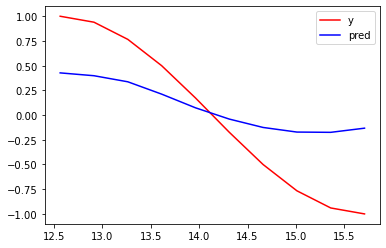

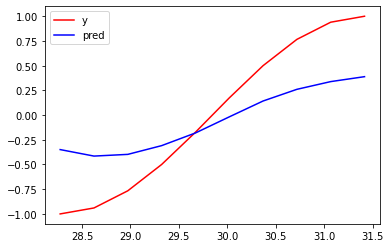

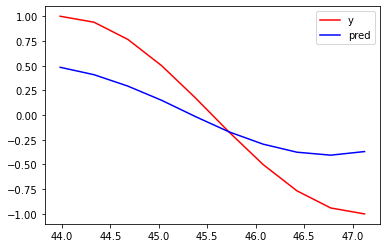

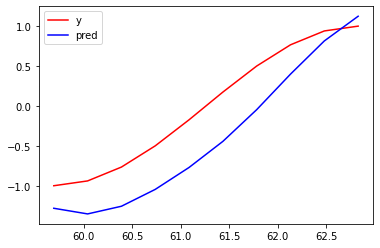

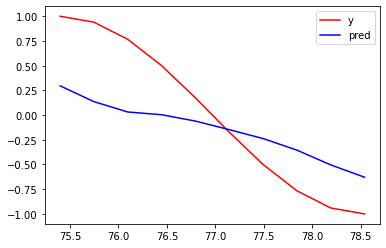

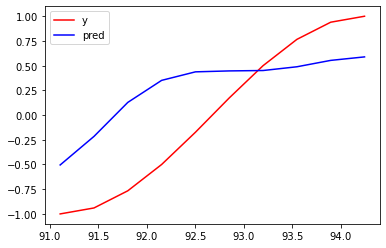

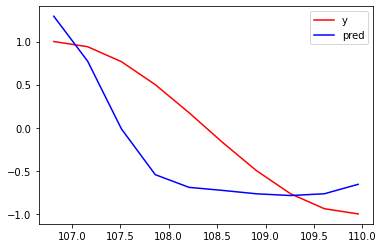

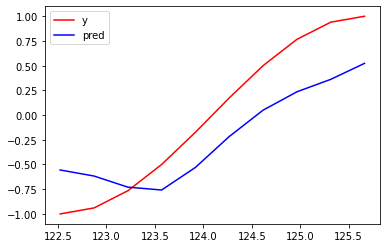

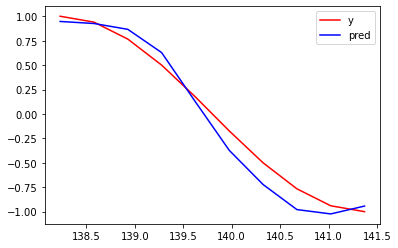

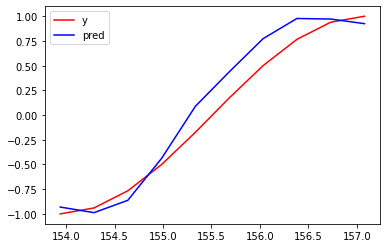

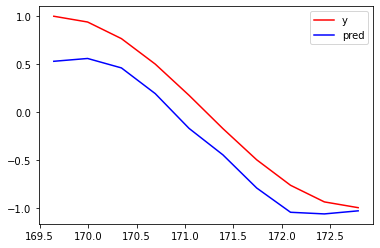

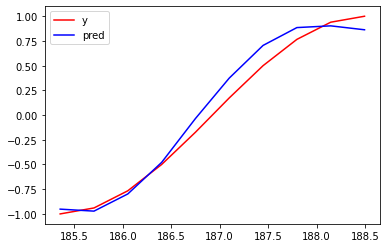

In [5]:
for epoch in range(EPOCH):
    start, end = epoch * np.pi, (epoch + 1) * np.pi
    # using sin predicts cos
    t = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x = np.sin(t)
    y = np.cos(t)
    
    # I/O.shape = (BATCH_SIZE, TIME_STPE, I/O_SIZE)
    batch_x = Variable(torch.from_numpy(x[np.newaxis, :, np.newaxis]))
    batch_y = Variable(torch.from_numpy(y[np.newaxis, :, np.newaxis]))
    
    y_pred, h_state = rnn(batch_x, h_state)
    # important!!!
    # repack the hidden state, break the connection from last i
    h_state = Variable(h_state.data)
    
    loss = loss_fn(y_pred, batch_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 4:
        plt.plot(t, y, 'r-', label='y')
        plt.plot(t, y_pred.detach().numpy().flatten(), 'b-', label='pred')
        plt.legend()
        plt.draw()
        plt.pause(0.05)